## 데이터셋 만들기

In [1]:
path_to_label = './data/gtFine/mask-only/labels/'
path_to_image = './data/imgsFine/leftImg8bit/mask-only/'

In [11]:
import glob
import torch
import numpy as np

from torch.utils.data.dataset import Dataset

from PIL import Image

In [52]:
class Garbage(Dataset):
    def __init__(self, path_to_image, path_to_label, train = True, transforms = None, input_size = (128, 128)):
        self.images = sorted(glob.glob(path_to_image+'*.png'))
        self.labels = sorted(glob.glob(path_to_label+'*.png'))
        
        self.X_train = list(filter(lambda x: x.split('_')[1][0] in ['1', '2'], self.images))
        self.X_test = list(filter(lambda x: x.split('_')[1][0] == '3', self.images))
        
        self.Y_train = list(filter(lambda x: x.split('_')[1][0] in ['1', '2'], self.labels))
        self.Y_test = list(filter(lambda x: x.split('_')[1][0] == '3', self.labels))
        
        self.train = train
        self.transforms = transforms
        self.input_size = input_size
        
    def __len__(self):
        if self.train:
            return len(self.X_train)
        else:
            return len(self.X_test)
        
    def preprocess_mask(self, mask):
        mask = mask.resize(self.input_size)
        mask = np.array(mask).astype(np.float32)
        mask = torch.tensor(mask)
        return mask
    
    def __getitem__(self, i):
        if self.train:
            X_train = Image.open(self.X_train[i])
            X_train = self.transforms(X_train)
            Y_train = Image.open(self.Y_train[i])
            Y_train = self.preprocess_mask(Y_train)
            return X_train, Y_train
        else:
            X_test = Image.open(self.X_test[i])
            X_test = self.transforms(X_test)
            Y_test = Image.open(self.Y_test[i])
            Y_test = self.preprocess_mask(Y_test)
            return X_test, Y_test

In [25]:
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.enc1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc5_1 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.enc5_2 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        
        self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
        self.dec4_1 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dec4_2 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        
        self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride=2)
        self.dec3_1 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec3_2 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        
        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride=2)
        self.dec2_1 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec2_2 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        
        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.dec1_1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec1_3 = nn.Conv2d(64, 1, kernel_size=1)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.enc1_1(x)
        x = self.relu(x)
        e1 = self.enc1_2(x)
        e1 = self.relu(e1)
        x = self.pool1(e1)
            
        x = self.enc2_1(x)
        x = self.relu(x)
        e2 = self.enc2_2(x)
        e2 = self.relu(e2)
        x = self.pool2(e2)
            
        x = self.enc3_1(x)
        x = self.relu(x)
        e3 = self.enc3_2(x)
        e3 = self.relu(e3)
        x = self.pool3(e3)
            
        x = self.enc4_1(x)
        x = self.relu(x)
        e4 = self.enc4_2(x)
        e4 = self.relu(e4)
        x = self.pool4(e4)
            
        x = self.enc5_1(x)
        x = self.relu(x)
        x = self.enc5_2(x)
        x = self.relu(x)
            
        x = self.upsample4(x)
        x = torch.cat([x, e4], dim=1)
        x = self.dec4_1(x)
        x = self.relu(x)
        x = self.dec4_2(x)
        x = self.relu(x)
            
        x = self.upsample3(x)
        x = torch.cat([x, e3], dim=1)
        x = self.dec3_1(x)
        x = self.relu(x)
        x = self.dec3_2(x)
        x = self.relu(x)
            
        x = self.upsample2(x)
        x = torch.cat([x, e2], dim=1)
        x = self.dec2_1(x)
        x = self.relu(x)
        x = self.dec2_2(x)
        x = self.relu(x)
            
        x = self.upsample1(x)
        x = torch.cat([x, e1], dim=1)
        x = self.dec1_1(x)
        x = self.relu(x)
        x = self.dec1_2(x)
        x = self.relu(x)
        x = self.dec1_3(x)
            
        x = torch.squeeze(x)
            
        return x

In [16]:
import tqdm

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor, Resize
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = Compose([
    Resize((128, 128)),
    ToTensor()
])

In [53]:
train_set = Garbage(path_to_image=path_to_image, path_to_label=path_to_label, transforms=transform)
test_set = Garbage(path_to_image=path_to_image, path_to_label=path_to_label, transforms=transform, train=False)

train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = DataLoader(test_set)

In [27]:
model = UNet().to(device)
learning_rate = 0.0001
optim = Adam(params=model.parameters(), lr=learning_rate)

In [65]:
for epoch in range(200):
    iterator = tqdm.tqdm(train_loader)
    
    for data, label in iterator:
        optim.zero_grad()
        
        preds = model(data.to(device))
        loss = nn.CrossEntropyLoss()(preds, label.type(torch.FloatTensor).to(device))
        loss.backward()
        
        optim.step()
        
        iterator.set_description(f'epoch{epoch+1} loss:{loss.item()}')
        
torch.save(model.state_dict(), './UNet.pth')

epoch68 loss:793.4180908203125: 100%|████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.94it/s]


epoch136 loss:331.03436279296875: 100%|██████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.18it/s]


epoch200 loss:359.09088134765625: 100%|██████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.06it/s]


In [37]:
len(train_set)

14

In [54]:
len(test_set)

7

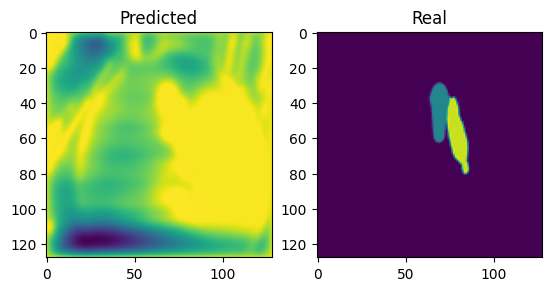

In [66]:
import matplotlib.pyplot as plt

model.load_state_dict(torch.load('./UNet.pth'))
data, label = test_set[1]
pred = model(torch.unsqueeze(data.to(device), dim=0))

with torch.no_grad():
    plt.subplot(1,2,1)
    plt.title('Predicted')
    plt.imshow(pred.cpu())
    plt.subplot(1,2,2)
    plt.title('Real')
    plt.imshow(label)
    plt.show()